Import packages

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, floor, lit, sum as spark_sum, count as spark_count, to_date, when
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType

Start spark session and load data from parquet

In [ ]:
spark_session = (SparkSession.builder
                    .master('local[*]')
                    .config("spark.executor.memory", "8g")
                    .config("spark.driver.memory", "4g")
                    .appName('SparkClean')
                    .getOrCreate())   

In [3]:
df = spark_session.read.parquet(
    "reviews.parquet",
    header=True,
    inferSchema=True
)

df.printSchema()

root
 |-- recommendation_id: integer (nullable = true)
 |-- app_id: integer (nullable = true)
 |-- game_title: string (nullable = true)
 |-- author_steam_id: string (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_lifetime: float (nullable = true)
 |-- author_playtime_at_review: float (nullable = true)
 |-- author_last_played: timestamp (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- updated_at: timestamp (nullable = true)
 |-- is_voted_up: boolean (nullable = true)
 |-- num_votes_up: integer (nullable = true)
 |-- num_votes_funny: integer (nullable = true)
 |-- weighted_vote_score: float (nullable = true)
 |-- num_comment: integer (nullable = true)
 |-- is_purchased: boolean (nullable = true)
 |-- is_received_for_free: boolean (nullable = true)
 |-- is_written_during_early_access: boolean (null

In [4]:
df.show()

+-----------------+------+----------+-----------------+----------------------+------------------+------------------------+-------------------------+-------------------+---------+----------------------------------+-------------------+-------------------+-----------+------------+---------------+-------------------+-----------+------------+--------------------+------------------------------+
|recommendation_id|app_id|game_title|  author_steam_id|author_num_games_owned|author_num_reviews|author_playtime_lifetime|author_playtime_at_review| author_last_played| language|                            review|         created_at|         updated_at|is_voted_up|num_votes_up|num_votes_funny|weighted_vote_score|num_comment|is_purchased|is_received_for_free|is_written_during_early_access|
+-----------------+------+----------+-----------------+----------------------+------------------+------------------------+-------------------------+-------------------+---------+----------------------------------+---

In [4]:
# Ids
COL_RECOMMENDATION_ID = "recommendation_id"
COL_APP_ID = "app_id"
COL_AUTHOR_STEAM_ID = "author_steam_id" 

# Game
COL_GAME_TITLE = "game_title"

# Author
COL_AUTHOR_NUM_GAMES = "author_num_games_owned"
COL_AUTHOR_NUM_REVIEWS = "author_num_reviews"
COL_AUTHOR_PLAYTIME_LIFETIME = "author_playtime_lifetime" # lifetime playtime tracked in game (originaly in minutes, later converted to hours)
COL_AUTHOR_PLAYTIME_AT_REVIEW = "author_playtime_at_review" # playtime when the review was written (originaly in minutes, later converted to hours)
COL_AUTHOR_LAST_PLAYED = "author_last_played"

AUTHOR_COLUMNS = [COL_AUTHOR_NUM_GAMES, COL_AUTHOR_NUM_REVIEWS, COL_AUTHOR_PLAYTIME_LIFETIME, COL_AUTHOR_PLAYTIME_AT_REVIEW, COL_AUTHOR_LAST_PLAYED]

# Review details
COL_LANGUAGE = "language"
COL_REVIEW = "review" # review text
COL_CREATED_AT = "created_at"
COL_UPDATED_AT = "updated_at"
COL_IS_VOTED_UP = "is_voted_up" # if the review was positive or negative

REVIEW_DETAILS_COLUMNS = [COL_LANGUAGE, COL_REVIEW, COL_CREATED_AT, COL_UPDATED_AT, COL_IS_VOTED_UP]

# Players response to the review
COL_NUM_VOTES_UP = "num_votes_up" # number of people who voted the review up
COL_NUM_VOTES_FUNNY = "num_votes_funny" # number of people who voted the review funny
COL_WEIGHTED_VOTE_SCORE = "weighted_vote_score" # a helpfulness score (steam generated)
COL_NUM_COMMENTS = "num_comment" # number of comments to the review

PLAYERS_RESPONSE_COLUMNS = [COL_NUM_VOTES_UP, COL_NUM_VOTES_FUNNY, COL_WEIGHTED_VOTE_SCORE, COL_NUM_COMMENTS]

# Game state at a time of the review
COL_IS_PURCHASED = "is_purchased" # if the user purchased the game on Steam
COL_IS_RECEIVED_FOR_FREE = "is_received_for_free" # true if the user checked a box saying they got the app for free
COL_IS_WRITTEN_DURING_EARLY_ACCESS = "is_written_during_early_access" # if the user posted this review while the game was in Early Access

PURCHASE_STATE_COLUMNS = [COL_IS_PURCHASED, COL_IS_RECEIVED_FOR_FREE, COL_IS_WRITTEN_DURING_EARLY_ACCESS]

Analyse numerical columns

In [5]:
NUMERIC_COLUMNS = [
    COL_AUTHOR_NUM_GAMES, 
    COL_AUTHOR_NUM_REVIEWS, 
    COL_AUTHOR_PLAYTIME_LIFETIME,
    COL_AUTHOR_PLAYTIME_AT_REVIEW, 
    COL_NUM_VOTES_UP, 
    COL_NUM_VOTES_FUNNY, 
    COL_WEIGHTED_VOTE_SCORE,
    COL_NUM_COMMENTS
]

In [7]:
df.select(NUMERIC_COLUMNS).describe().show()

+-------+----------------------+------------------+------------------------+-------------------------+-----------------+------------------+-------------------+-------------------+
|summary|author_num_games_owned|author_num_reviews|author_playtime_lifetime|author_playtime_at_review|     num_votes_up|   num_votes_funny|weighted_vote_score|        num_comment|
+-------+----------------------+------------------+------------------------+-------------------------+-----------------+------------------+-------------------+-------------------+
|  count|             110873378|         110873378|               110873378|                110873378|        110873378|         110873378|          110873378|          110873377|
|   mean|    122.83909300571685|25.480647734932365|      258.27630412383684|       118.83945350742985|2.108693125594135|0.6966713325898666|0.17629661010754044|0.09901125317036208|
| stddev|    467.02327747553966|166.20974874198484|       763.1582313102062|       409.8623037113914

Check for leftover NULL values

In [8]:
# COL_AUTHOR_LAST_PLAYED has intentional nulls in case player has never played the game
exclude_columns = [COL_AUTHOR_LAST_PLAYED]
columns_to_check = [c for c in df.columns if c not in exclude_columns]

null_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in columns_to_check])

In [9]:
null_counts.repartition(4).show()

+-----------------+------+----------+---------------+----------------------+------------------+------------------------+-------------------------+--------+------+----------+----------+-----------+------------+---------------+-------------------+-----------+------------+--------------------+------------------------------+
|recommendation_id|app_id|game_title|author_steam_id|author_num_games_owned|author_num_reviews|author_playtime_lifetime|author_playtime_at_review|language|review|created_at|updated_at|is_voted_up|num_votes_up|num_votes_funny|weighted_vote_score|num_comment|is_purchased|is_received_for_free|is_written_during_early_access|
+-----------------+------+----------+---------------+----------------------+------------------+------------------------+-------------------------+--------+------+----------+----------+-----------+------------+---------------+-------------------+-----------+------------+--------------------+------------------------------+
|                0|     0|     

In [6]:
df = df.dropna(subset=COL_NUM_COMMENTS)

Create helper functions for grouping data into bins for efficient outlier detection and visualization 

In [7]:
def group_into_bins(df, col_name, num_bins=250):
    min_val, max_val = df.selectExpr(f"min({col_name})", f"max({col_name})").first()
    bin_size = (max_val - min_val) / num_bins

    binned_df = df.withColumn("bin", floor((col(col_name) - min_val) / bin_size)) \
                  .groupBy("bin").agg(spark_count("*").alias("count")) \
                  .withColumn("bin_upper_value", col("bin") * lit(bin_size) + lit(bin_size) + lit(min_val)) \
                  .orderBy("bin")

    return binned_df, bin_size, min_val, max_val

def plot_bins(binned_df, bin_size, column_name):
    binned_pandas_df = binned_df.toPandas()

    plt.figure(figsize=(10, 6))
    plt.bar(binned_pandas_df["bin_upper_value"], binned_pandas_df["count"], width=bin_size, edgecolor="k", color="plum")
    plt.title(f"Histogram of {column_name}")
    plt.xlabel(f"Classes of {column_name}")
    plt.ylabel(f"Count for class of {column_name}")
    plt.show()
    
def calculate_outlier_bounds(binned_df):
    window_spec = Window.orderBy("bin_upper_value")

    binned_df = binned_df.withColumn("cum_count", spark_sum("count").over(window_spec))

    total_count = binned_df.agg(spark_sum("count").alias("total")).first()["total"]

    binned_df = binned_df.withColumn("percentile", col("cum_count") / total_count)
    
    Q1_row = binned_df.filter(col("percentile") >= 0.25).orderBy("percentile").first()
    Q3_row = binned_df.filter(col("percentile") >= 0.75).orderBy("percentile").take(3)[-1]

    Q1 = Q1_row["bin_upper_value"]
    Q3 = Q3_row["bin_upper_value"]
    IQR = Q3 - Q1

    lower_bound = Q1 - 2.5 * IQR
    upper_bound = Q3 + 2.5 * IQR

    return lower_bound, upper_bound

Save the df into a variable

In [8]:
master_df = df
master_df.count()

110873377

Go over some columns with outliers and process them

Processing column: author_num_games_owned
+---+--------+---------------+
|bin|   count|bin_upper_value|
+---+--------+---------------+
|  0|88925327|        133.404|
|  1|10182969|        266.808|
|  2| 4304489|        400.212|
|  3| 2167734|        533.616|
|  4| 1325067|         667.02|
|  5|  835764|        800.424|
|  6|  581647|        933.828|
|  7|  427943|       1067.232|
|  8|  332714|       1200.636|
|  9|  270579|        1334.04|
| 10|  200838|       1467.444|
| 11|  152340|       1600.848|
| 12|  134348|       1734.252|
| 13|  116080|       1867.656|
| 14|  103800|        2001.06|
| 15|   83506|       2134.464|
| 16|   69961|       2267.868|
| 17|   59409|       2401.272|
| 18|   49322|       2534.676|
| 19|   38679|        2668.08|
+---+--------+---------------+
only showing top 20 rows



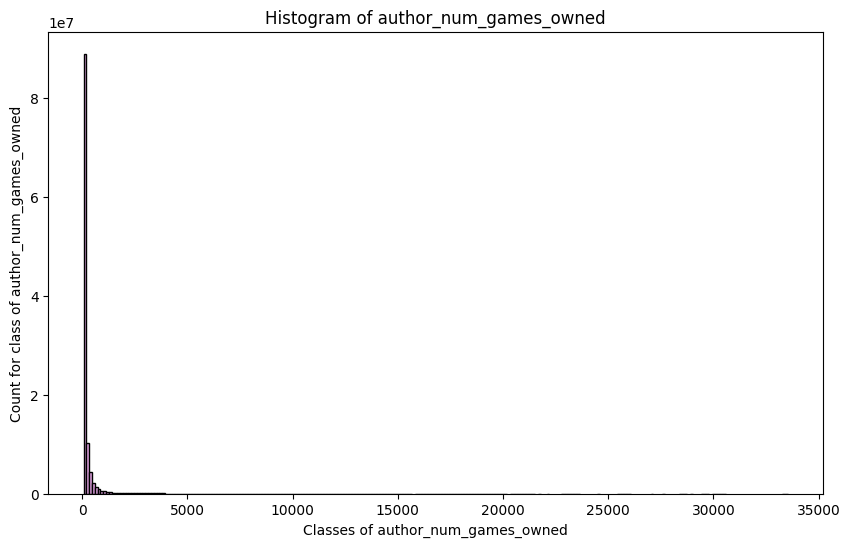

Lower Bound: -533.616, Upper Bound: 1067.232
+---+--------+------------------+
|bin|   count|   bin_upper_value|
+---+--------+------------------+
|  0|56814394|             4.268|
|  1| 1555968|             8.536|
|  2| 1574163|12.803999999999998|
|  3| 1955688|            17.072|
|  4| 1530020|             21.34|
|  5| 1482724|            25.608|
|  6| 1449368|29.875999999999998|
|  7| 1733048|            34.144|
|  8| 1326793|            38.412|
|  9| 1269662|             42.68|
| 10| 1221166|            46.948|
| 11| 1446368|            51.216|
| 12| 1114366|55.483999999999995|
| 13| 1068661|59.751999999999995|
| 14| 1265042|             64.02|
| 15|  963206|            68.288|
| 16|  926357|            72.556|
| 17|  883588|            76.824|
| 18| 1048381|            81.092|
| 19|  799494|             85.36|
+---+--------+------------------+
only showing top 20 rows



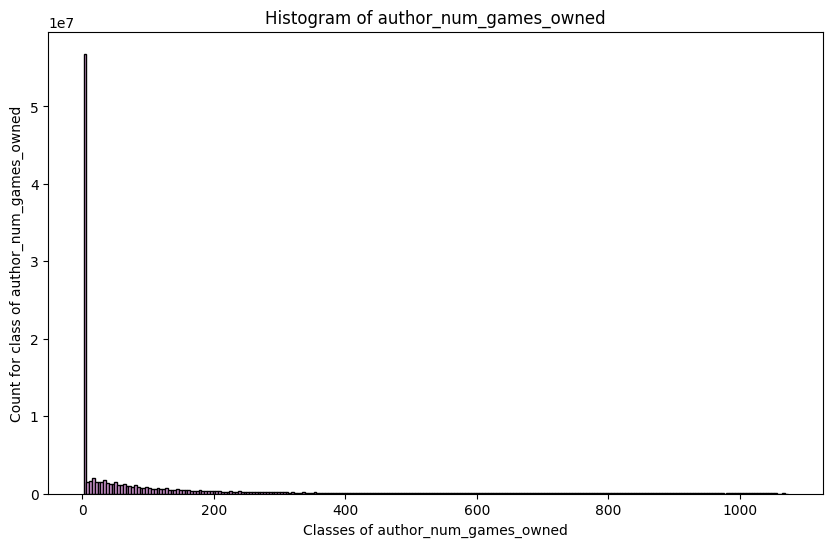

Processing column: author_num_reviews
+---+---------+------------------+
|bin|    count|   bin_upper_value|
+---+---------+------------------+
|  0|100193273|             42.78|
|  1|  5912751|             84.56|
|  2|  1906771|            126.34|
|  3|   853093|            168.12|
|  4|   469603|             209.9|
|  5|   306540|            251.68|
|  6|   197715|293.46000000000004|
|  7|   145048|            335.24|
|  8|   108942|            377.02|
|  9|    93198|418.79999999999995|
| 10|    64372|460.58000000000004|
| 11|    55831|            502.36|
| 12|    32880|            544.14|
| 13|    38470|            585.92|
| 14|    40768|             627.7|
| 15|    37726|            669.48|
| 16|    21376|            711.26|
| 17|    23288|            753.04|
| 18|    19812| 794.8199999999999|
| 19|    20474|             836.6|
+---+---------+------------------+
only showing top 20 rows



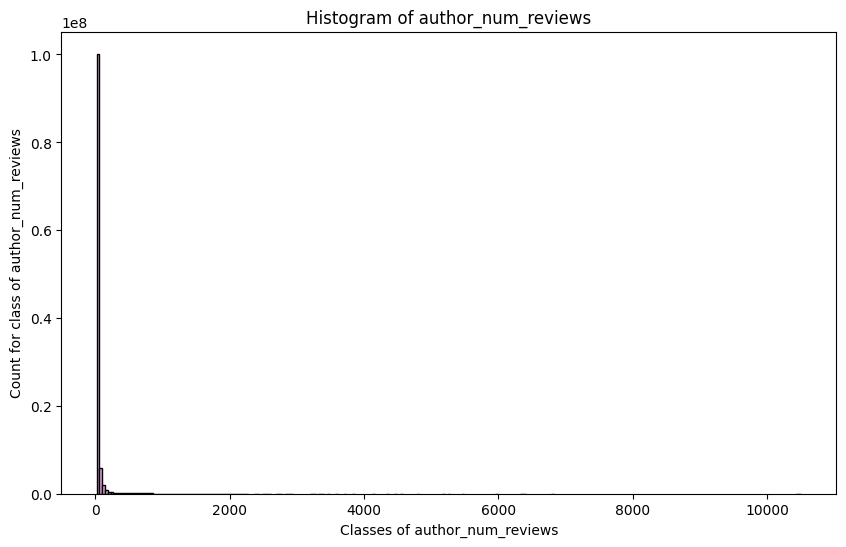

Lower Bound: -166.12, Upper Bound: 335.24
+---+--------+------------------+
|bin|   count|   bin_upper_value|
+---+--------+------------------+
|  0|32287192|2.3360000000000003|
|  1| 9325035|             3.672|
|  2|13286932|             5.008|
|  3| 4963522|             6.344|
|  4| 4185290| 7.680000000000001|
|  5| 6656961|             9.016|
|  6| 2711493|            10.352|
|  7| 2377891|            11.688|
|  8| 3994949|13.024000000000001|
|  9| 1691662|14.360000000000001|
| 10| 1527703|15.696000000000002|
| 11| 2662275|            17.032|
| 12| 1164486|            18.368|
| 13| 1070392|            19.704|
| 14| 1911164|             21.04|
| 15|  842907|            22.376|
| 16|  788782|            23.712|
| 17| 1427476|            25.048|
| 18|  646078|            26.384|
| 19|  604154|             27.72|
+---+--------+------------------+
only showing top 20 rows



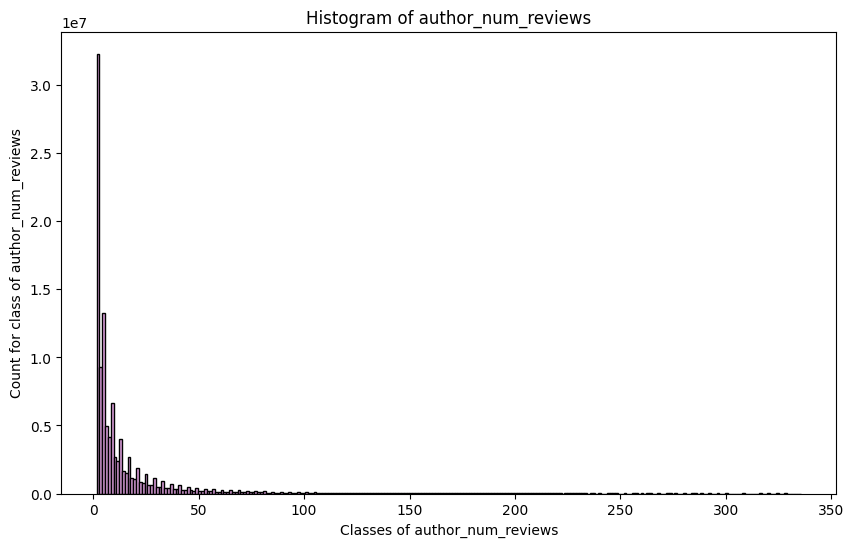

Processing column: author_playtime_lifetime
+---+--------+------------------+
|bin|   count|   bin_upper_value|
+---+--------+------------------+
|  0|94730271|      400.53234375|
|  1| 6882447|       801.0646875|
|  2| 3223105|1201.5970312499999|
|  3| 1928286|       1602.129375|
|  4| 1197436|     2002.66171875|
|  5|  795239|      2403.1940625|
|  6|  540624|     2803.72640625|
|  7|  377315|        3204.25875|
|  8|  271167|     3604.79109375|
|  9|  197795|      4005.3234375|
| 10|  149203|     4405.85578125|
| 11|  112067|       4806.388125|
| 12|   85569|     5206.92046875|
| 13|   67170|      5607.4528125|
| 14|   52409|     6007.98515625|
| 15|   41889|         6408.5175|
| 16|   33278|     6809.04984375|
| 17|   26659|      7209.5821875|
| 18|   22011|     7610.11453125|
| 19|   18171|       8010.646875|
+---+--------+------------------+
only showing top 20 rows



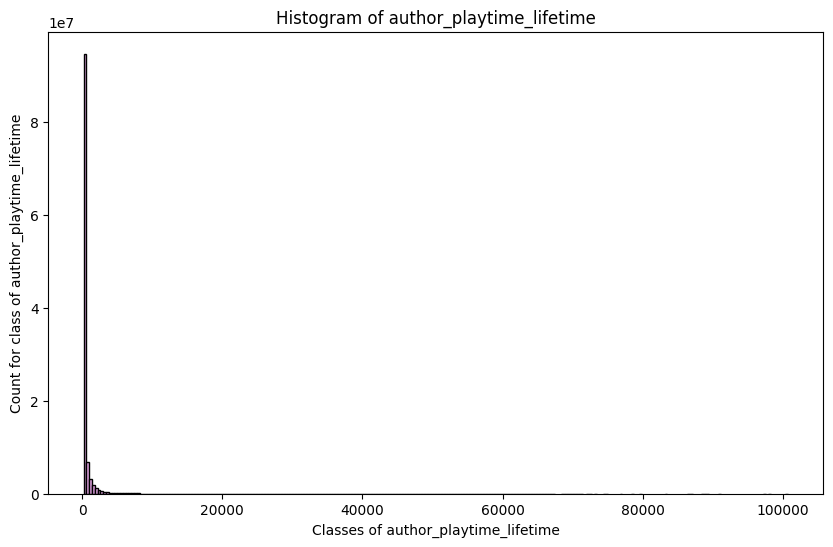

Lower Bound: -1602.1293749999995, Upper Bound: 3204.2587499999995
+---+--------+------------------+
|bin|   count|   bin_upper_value|
+---+--------+------------------+
|  0|33012140|            12.817|
|  1|13886901|            25.634|
|  2| 8421038|            38.451|
|  3| 5966718|            51.268|
|  4| 4512691| 64.08500000000001|
|  5| 3562118| 76.90200000000002|
|  6| 2915190|            89.719|
|  7| 2452326|           102.536|
|  8| 2124689|115.35300000000001|
|  9| 1835349|128.17000000000002|
| 10| 1608403|140.98700000000002|
| 11| 1426344|           153.804|
| 12| 1272206|           166.621|
| 13| 1145895|179.43800000000002|
| 14| 1038811|           192.255|
| 15|  949708|           205.072|
| 16|  873455|           217.889|
| 17|  804084|230.70600000000002|
| 18|  744465|243.52300000000002|
| 19|  693544|            256.34|
+---+--------+------------------+
only showing top 20 rows



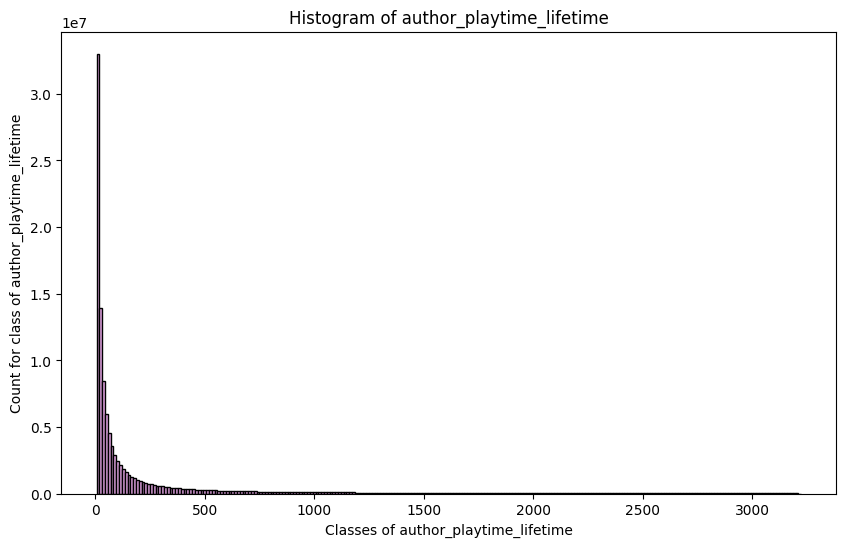

Processing column: author_playtime_at_review
+---+---------+------------------+
|bin|    count|   bin_upper_value|
+---+---------+------------------+
|  0|101589473|           325.345|
|  1|  4304001|            650.69|
|  2|  1818359| 976.0350000000001|
|  3|  1314137|           1301.38|
|  4|   591765|1626.7250000000001|
|  5|   361872|1952.0700000000002|
|  6|   246915|          2277.415|
|  7|   161956|           2602.76|
|  8|   112782|2928.1050000000005|
|  9|    84158|3253.4500000000007|
| 10|    59903|          3578.795|
| 11|    43385|3904.1400000000003|
| 12|    34963| 4229.485000000001|
| 13|    26114| 4554.830000000001|
| 14|    19784|          4880.175|
| 15|    17326|           5205.52|
| 16|    13170| 5530.865000000001|
| 17|    10541| 5856.210000000001|
| 18|     9024| 6181.555000000001|
| 19|     7137| 6506.900000000001|
+---+---------+------------------+
only showing top 20 rows



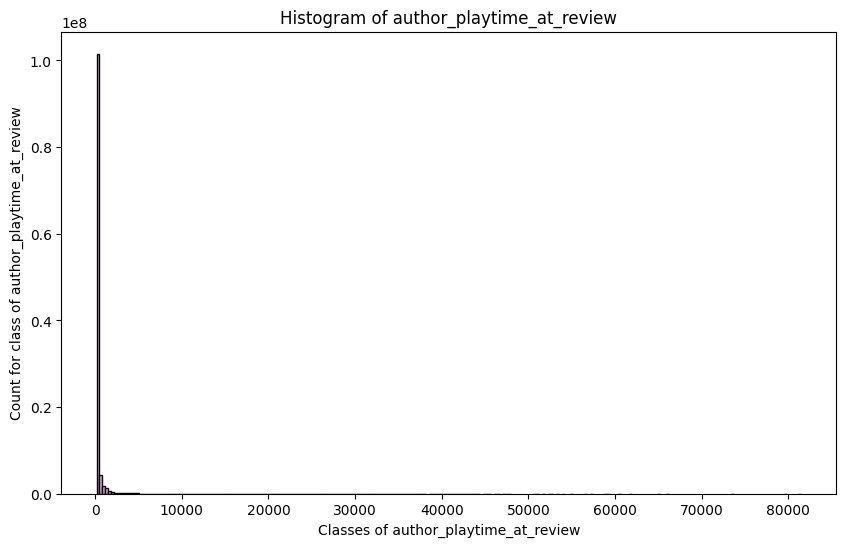

Lower Bound: -1301.38, Upper Bound: 2602.76
+---+--------+------------------+
|bin|   count|   bin_upper_value|
+---+--------+------------------+
|  0|46097577|            10.411|
|  1|16008870|            20.822|
|  2| 8365575|31.232999999999997|
|  3| 5831306|            41.644|
|  4| 4007050|            52.055|
|  5| 2970424|            62.466|
|  6| 2353374|            72.877|
|  7| 1899814|            83.288|
|  8| 1575358|            93.699|
|  9| 1423446|            104.11|
| 10| 1197831|           114.521|
| 11| 1031160|           124.932|
| 12|  904550|           135.343|
| 13|  804857|           145.754|
| 14|  723184|           156.165|
| 15|  648297|           166.576|
| 16|  591615|           176.987|
| 17|  539054|           187.398|
| 18|  499875|           197.809|
| 19|  487214|            208.22|
+---+--------+------------------+
only showing top 20 rows



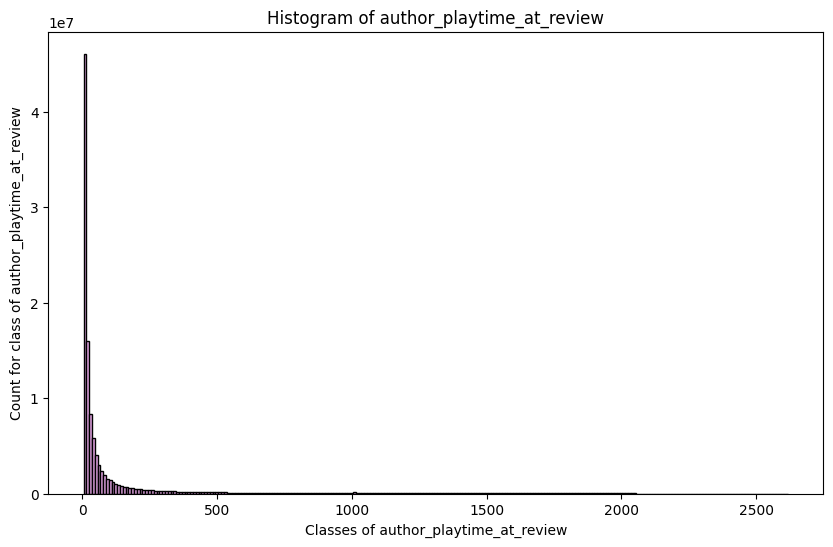

In [9]:
columns_to_plot = [
    COL_AUTHOR_NUM_GAMES, 
    COL_AUTHOR_NUM_REVIEWS, 
    COL_AUTHOR_PLAYTIME_LIFETIME,
    COL_AUTHOR_PLAYTIME_AT_REVIEW, 
]

for column in columns_to_plot:
    print(f"Processing column: {column}")
    
    binned_df, bin_size, min_val, max_val = group_into_bins(df, column)
    binned_df.show()
    plot_bins(binned_df, bin_size, column)
    
    lower_bound, upper_bound = calculate_outlier_bounds(binned_df)
    print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    
    master_df = master_df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    local_filtered_df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    
    binned_filtered_df, bin_size, min_val, max_val = group_into_bins(local_filtered_df, column)
    binned_filtered_df.show()
    plot_bins(binned_filtered_df, bin_size, column)


Check how many rows have been deleted as outliers (~3 million which is slightly less then 3% of the data)

In [10]:
master_df.count()

107049200

Add new columns for deeper analysis

In [ ]:
COL_AUTHOR_REVIEWS_PER_GAME = "author_reviews_per_game" # number of reviews player has written per game they own (supposed to show normilized user activity)
COL_REVIEW_TOTAL_ENGAGEMENT = "review_total_engagement" # number of all votes up and funny (sadly votes down are not collected)
COL_REVIEW_COMMENT_PER_ENGAGEMENT_VOTE = "review_comment_per_vote" # number of comments per vote (supposed to show normilized review comment engagement)

df = master_df.withColumn(
    COL_AUTHOR_REVIEWS_PER_GAME,
    when(col(COL_AUTHOR_NUM_GAMES) > 0, col(COL_AUTHOR_NUM_REVIEWS) / col(COL_AUTHOR_NUM_GAMES)).otherwise(0)
)

df = df.withColumn(
    COL_REVIEW_TOTAL_ENGAGEMENT,
    col(COL_NUM_VOTES_UP) + col(COL_NUM_VOTES_FUNNY)
)

df = df.withColumn(
    COL_REVIEW_COMMENT_PER_ENGAGEMENT_VOTE,
    when(col(COL_REVIEW_TOTAL_ENGAGEMENT) > 0, col(COL_NUM_COMMENTS) / col(COL_REVIEW_TOTAL_ENGAGEMENT)).otherwise(0)
)

df.printSchema()
df.select(COL_AUTHOR_REVIEWS_PER_GAME, COL_REVIEW_TOTAL_ENGAGEMENT, COL_REVIEW_COMMENT_PER_ENGAGEMENT_VOTE).show(5)

root
 |-- recommendation_id: integer (nullable = true)
 |-- app_id: integer (nullable = true)
 |-- game_title: string (nullable = true)
 |-- author_steam_id: string (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_lifetime: float (nullable = true)
 |-- author_playtime_at_review: float (nullable = true)
 |-- author_last_played: timestamp (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- updated_at: timestamp (nullable = true)
 |-- is_voted_up: boolean (nullable = true)
 |-- num_votes_up: integer (nullable = true)
 |-- num_votes_funny: integer (nullable = true)
 |-- weighted_vote_score: float (nullable = true)
 |-- num_comment: integer (nullable = true)
 |-- is_purchased: boolean (nullable = true)
 |-- is_received_for_free: boolean (nullable = true)
 |-- is_written_during_early_access: boolean (null

In [ ]:
df = df.withColumn(
    COL_AUTHOR_REVIEWS_PER_GAME,
    col(COL_AUTHOR_REVIEWS_PER_GAME).cast(FloatType())
)
 
df = df.withColumn(
    COL_REVIEW_COMMENT_PER_ENGAGEMENT_VOTE,
    col(COL_REVIEW_COMMENT_PER_ENGAGEMENT_VOTE).cast(FloatType())
)

In [17]:
df.printSchema()

root
 |-- recommendation_id: integer (nullable = true)
 |-- app_id: integer (nullable = true)
 |-- game_title: string (nullable = true)
 |-- author_steam_id: string (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_lifetime: float (nullable = true)
 |-- author_playtime_at_review: float (nullable = true)
 |-- author_last_played: timestamp (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- updated_at: timestamp (nullable = true)
 |-- is_voted_up: boolean (nullable = true)
 |-- num_votes_up: integer (nullable = true)
 |-- num_votes_funny: integer (nullable = true)
 |-- weighted_vote_score: float (nullable = true)
 |-- num_comment: integer (nullable = true)
 |-- is_purchased: boolean (nullable = true)
 |-- is_received_for_free: boolean (nullable = true)
 |-- is_written_during_early_access: boolean (null

Save the data to new parquet file

In [18]:
output_path = "reviews-clean.parquet"

df.write.mode("overwrite").parquet(output_path)